# AVO 正演

In [24]:
import warnings
from pathlib import Path

import bruges
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate, signal

warnings.filterwarnings("ignore")

# 设置中文字体
plt.rcParams["font.family"] = "SimHei"  # 黑体 SimHei 支持中文
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

In [25]:
# =============================================================================
# 1. 参数配置类
# =============================================================================


class AVOConfig:
    """AVO正演模拟配置参数"""

    def __init__(self):
        # 默认参数
        self.f_dom = 25.0  # 主频 (Hz)
        self.h_max = 5.0  # 最大深度步长 (m)
        self.dt = 0.002  # 时间采样 (s) - 2ms
        self.angle_min = 0  # 最小入射角 (度)
        self.angle_max = 60  # 最大入射角 (度)
        self.angle_step = 1  # 角度步长 (度)
        self.wavelet_type = "ricker"  # 子波类型
        self.interp_method = "cubic"  # 插值方法: 'linear' 或 'cubic'
        self.antialias = True  # 是否应用抗混叠滤波

    def get_angles(self):
        """获取角度数组"""
        return np.arange(self.angle_min, self.angle_max + self.angle_step, self.angle_step)


In [26]:
# =============================================================================
# 2. 数据预处理模块
# =============================================================================


class DataProcessor:
    """数据预处理类"""

    def __init__(self, config: AVOConfig):
        self.config = config

    def load_well_data(self, excel_path):
        """
        加载井数据

        参数:
            excel_path: Excel文件路径

        返回:
            DataFrame: 包含DEPTH, VP, VS, RHOB列的数据
        """
        try:
            df = pd.read_excel(excel_path)

            # 检查必需列
            required_cols = ["DEPTH", "VP", "VS", "RHOB"]
            missing_cols = [col for col in required_cols if col not in df.columns]

            if missing_cols:
                # 尝试常见的列名变体
                col_mapping = {
                    "depth": "DEPTH",
                    "Depth": "DEPTH",
                    "vp": "VP",
                    "Vp": "VP",
                    "vs": "VS",
                    "Vs": "VS",
                    "rhob": "RHOB",
                    "RHO": "RHOB",
                    "DENSITY": "RHOB",
                }

                for old_name, new_name in col_mapping.items():
                    if old_name in df.columns:
                        df.rename(columns={old_name: new_name}, inplace=True)

                # 再次检查
                missing_cols = [col for col in required_cols if col not in df.columns]
                if missing_cols:
                    raise ValueError(f"缺少必需列: {missing_cols}")

            # 数据清理
            df = df.dropna(subset=required_cols)
            df = df.sort_values("DEPTH").reset_index(drop=True)

            # 单位转换检查
            if df["RHOB"].mean() > 10:  # 可能是 kg/m3，转换为 g/cm3
                df["RHOB"] = df["RHOB"] / 1000
                print("密度单位从 kg/m3 转换为 g/cm3")

            print(f"成功加载井数据: {len(df)} 行")
            print(f"深度范围: {df['DEPTH'].min():.1f} - {df['DEPTH'].max():.1f} m")

            return df

        except Exception as e:
            raise RuntimeError(f"加载井数据失败: {e}")

    def calculate_target_spacing(self, vp_mean):
        """
        计算目标深度步长

        参数:
            vp_mean: 平均P波速度

        返回:
            float: 目标深度步长
        """
        lambda_mean = vp_mean / self.config.f_dom
        h_target = min(lambda_mean / 8, self.config.h_max)
        return h_target

    def resample_data(self, df):
        """
        重采样井数据

        参数:
            df: 原始井数据

        返回:
            DataFrame: 重采样后的数据
        """
        # 计算平均速度
        vp_mean = df["VP"].mean()
        h_target = self.calculate_target_spacing(vp_mean)

        print(f"平均P波速度: {vp_mean:.0f} m/s")
        print(f"平均波长: {vp_mean / self.config.f_dom:.1f} m")
        print(f"目标采样间距: {h_target:.2f} m")

        # 创建新的深度网格
        depth_min = df["DEPTH"].min()
        depth_max = df["DEPTH"].max()
        new_depths = np.arange(depth_min, depth_max + h_target, h_target)

        # 抗混叠滤波（如果需要大幅降采样）
        original_spacing = np.median(np.diff(df["DEPTH"]))
        decimation_factor = h_target / original_spacing

        if self.config.antialias and decimation_factor > 2:
            print(f"应用抗混叠滤波，降采样因子: {decimation_factor:.1f}")
            # 设计低通滤波器
            nyquist_freq = 0.5 / original_spacing
            cutoff_freq = 0.4 / h_target  # 稍微保守的截止频率
            normalized_cutoff = cutoff_freq / nyquist_freq

            if normalized_cutoff < 1:
                b, a = signal.butter(4, normalized_cutoff, btype="low")  # type:ignore

                # 对每个参数应用滤波
                for col in ["VP", "VS", "RHOB"]:
                    df[col] = signal.filtfilt(b, a, df[col])

        # 插值
        resampled_data = {}
        resampled_data["DEPTH"] = new_depths

        for col in ["VP", "VS", "RHOB"]:
            if self.config.interp_method == "cubic":
                f = interpolate.interp1d(
                    df["DEPTH"],
                    df[col],
                    kind="cubic",
                    bounds_error=False,
                    fill_value="extrapolate",  # type:ignore
                )
            else:
                f = interpolate.interp1d(
                    df["DEPTH"],
                    df[col],
                    kind="linear",
                    bounds_error=False,
                    fill_value="extrapolate",  # type:ignore
                )

            resampled_data[col] = f(new_depths)

        df_resampled = pd.DataFrame(resampled_data)

        print(f"重采样完成: {len(df)} -> {len(df_resampled)} 行")

        return df_resampled

In [27]:
# # =============================================================================
# # DataProcessor 类测试代码
# # =============================================================================

# # 创建配置和处理器
# config = AVOConfig()
# processor = DataProcessor(config)

# print("=" * 60)
# print("DataProcessor 类测试")
# print("=" * 60)

# # 1. 测试数据加载
# print("\n1. 测试数据加载...")
# try:
#     well_data = processor.load_well_data("PH1.xlsx")
#     print("✓ 数据加载成功")

#     # 显示数据基本信息
#     print(f"数据形状: {well_data.shape}")
#     print(f"列名: {list(well_data.columns)}")
#     print("\n数据统计:")
#     print(well_data.describe())

# except Exception as e:
#     print(f"✗ 数据加载失败: {e}")

# # 2. 测试采样间距计算
# print(f"\n2. 测试采样间距计算...")
# if "well_data" in locals():
#     vp_mean = well_data["VP"].mean()
#     h_target = processor.calculate_target_spacing(vp_mean)
#     print(f"平均VP: {vp_mean:.1f} m/s")
#     print(f"目标采样间距: {h_target:.3f} m")
#     print(f"原始采样间距: {np.median(np.diff(well_data['DEPTH'])):.3f} m")

# # 3. 检查数据质量（异常值分析）
# print(f"\n3. 数据质量检查...")
# if "well_data" in locals():
#     fig, axes = plt.subplots(1, 4, figsize=(16, 4))

#     # 绘制原始数据和统计信息
#     for i, col in enumerate(["DEPTH", "VP", "VS", "RHOB"]):
#         ax = axes[i]
#         data = well_data[col]

#         # 计算异常值指标
#         Q1 = data.quantile(0.25)
#         Q3 = data.quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         outliers = data[(data < lower_bound) | (data > upper_bound)]

#         # 绘制数据
#         if col == "DEPTH":
#             ax.plot(range(len(data)), data, "b-", linewidth=0.5)
#             ax.set_ylabel("Depth (m)")
#         else:
#             ax.plot(data, well_data["DEPTH"], "b-", linewidth=0.5)
#             ax.invert_yaxis()
#             ax.set_xlabel(f"{col}")

#         ax.set_title(f"{col}\n异常值: {len(outliers)} ({len(outliers) / len(data) * 100:.1f}%)")
#         ax.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.suptitle("原始数据质量检查", y=1.02)
#     plt.show()

# # 4. 测试重采样（包含抗混叠滤波效果对比）
# print(f"\n4. 测试重采样和滤波效果...")
# if "well_data" in locals():
#     # 测试不同配置
#     configs_to_test = [("无抗混叠滤波", False), ("有抗混叠滤波", True)]

#     fig, axes = plt.subplots(2, 3, figsize=(15, 8))

#     for config_idx, (config_name, antialias_setting) in enumerate(configs_to_test):
#         # 临时修改配置
#         original_antialias = processor.config.antialias
#         processor.config.antialias = antialias_setting

#         print(f"\n  测试配置: {config_name}")

#         try:
#             resampled_data = processor.resample_data(well_data.copy())
#             print(f"  ✓ 重采样成功: {len(well_data)} -> {len(resampled_data)} 行")

#             # 绘制对比图
#             for param_idx, param in enumerate(["VP", "VS", "RHOB"]):
#                 ax = axes[config_idx, param_idx]

#                 # 原始数据
#                 ax.plot(well_data[param], well_data["DEPTH"], "b-", alpha=0.7, linewidth=0.5, label="原始")

#                 # 重采样数据
#                 ax.plot(resampled_data[param], resampled_data["DEPTH"], "r-", linewidth=1.5, label="重采样")

#                 ax.invert_yaxis()
#                 ax.set_xlabel(param)
#                 if param_idx == 0:
#                     ax.set_ylabel(f"Depth (m)\n{config_name}")
#                 ax.legend()
#                 ax.grid(True, alpha=0.3)

#                 # 计算数据变化统计
#                 original_std = well_data[param].std()
#                 resampled_std = resampled_data[param].std()
#                 smoothing_factor = (original_std - resampled_std) / original_std * 100
#                 ax.set_title(f"{param}\n平滑度: {smoothing_factor:.1f}%")

#         except Exception as e:
#             print(f"  ✗ 重采样失败: {e}")

#         # 恢复原始配置
#         processor.config.antialias = original_antialias

#     plt.tight_layout()
#     plt.suptitle("重采样效果对比", y=1.02)
#     plt.show()

# # 5. 测试边界情况
# print(f"\n5. 测试边界情况...")

# # 测试极小数据集
# print("  测试小数据集...")
# if "well_data" in locals():
#     small_data = well_data.head(50).copy()  # 只取前50行
#     try:
#         small_resampled = processor.resample_data(small_data)
#         print(f"  ✓ 小数据集处理成功: {len(small_data)} -> {len(small_resampled)} 行")
#     except Exception as e:
#         print(f"  ✗ 小数据集处理失败: {e}")

# # 测试数据中有NaN的情况
# print("  测试含NaN数据...")
# if "well_data" in locals():
#     nan_data = well_data.copy()
#     # 随机插入一些NaN
#     np.random.seed(42)
#     nan_indices = np.random.choice(len(nan_data), size=10, replace=False)
#     nan_data.loc[nan_indices, "VP"] = np.nan

#     try:
#         # 应该在load_well_data中被处理掉
#         print(f"  插入NaN前: {len(nan_data)} 行")
#         print(f"  NaN数量: {nan_data.isna().sum().sum()}")

#         # 模拟数据清理
#         cleaned_data = nan_data.dropna()
#         resampled_nan = processor.resample_data(cleaned_data)
#         print(f"  ✓ 含NaN数据处理成功: {len(cleaned_data)} -> {len(resampled_nan)} 行")
#     except Exception as e:
#         print(f"  ✗ 含NaN数据处理失败: {e}")

# print(f"\n" + "=" * 60)
# print("DataProcessor 测试完成")
# print("=" * 60)

# # 6. 总结和建议
# print(f"\n测试总结:")
# print("1. 关于异常值处理:")
# print("   - 低通滤波确实会自然平滑异常值")
# print("   - 地质数据中的'异常值'可能是真实现象")
# print("   - 建议：保持当前设计，不在滤波前处理异常值")
# print("\n2. 抗混叠滤波效果:")
# print("   - 当降采样因子>2时自动启用")
# print("   - 有效减少高频噪声和混叠")
# print("   - 轻微降低数据变异性（这是预期的）")
# print("\n3. 建议改进:")
# print("   - 可考虑添加数据质量报告功能")
# print("   - 可选择性地输出滤波前后对比")

In [28]:
# =============================================================================
# 3. 反射系数计算模块
# =============================================================================


class ReflectivityCalculator:
    """反射系数计算类"""

    def __init__(self, config: AVOConfig):
        self.config = config

    def calculate_interfaces(self, df):
        """
        计算界面参数（中点取值）

        参数:
            df: 重采样后的井数据

        返回:
            dict: 界面参数
        """
        n_layers = len(df) - 1

        interfaces = {
            "depth": (df["DEPTH"][1:].values + df["DEPTH"][:-1].values) / 2,
            "vp1": df["VP"][:-1].values,  # 上层
            "vs1": df["VS"][:-1].values,
            "rho1": df["RHOB"][:-1].values,
            "vp2": df["VP"][1:].values,  # 下层
            "vs2": df["VS"][1:].values,
            "rho2": df["RHOB"][1:].values,
        }

        return interfaces

    def zoeppritz_reflectivity(self, interfaces):
        """
        使用Zoeppritz方程计算反射系数

        参数:
            interfaces: 界面参数字典

        返回:
            ndarray: 反射系数矩阵 [n_interfaces, n_angles]
        """
        angles = self.config.get_angles()
        n_interfaces = len(interfaces["depth"])
        n_angles = len(angles)

        rpp = np.zeros((n_interfaces, n_angles))

        for i in range(n_interfaces):
            try:
                rpp[i, :] = bruges.reflection.zoeppritz_rpp(
                    interfaces["vp1"][i],
                    interfaces["vs1"][i],
                    interfaces["rho1"][i],
                    interfaces["vp2"][i],
                    interfaces["vs2"][i],
                    interfaces["rho2"][i],
                    angles,  # type:ignore
                )

                # 处理临界角和全反射
                rpp[i, :] = self._handle_critical_angles(rpp[i, :])

            except Exception as e:
                print(f"警告: 界面 {i} Zoeppritz计算失败: {e}")
                rpp[i, :] = 0

        return rpp

    def aki_richards_reflectivity(self, interfaces):
        """
        使用Aki-Richards近似计算反射系数
        """
        angles = self.config.get_angles()
        n_interfaces = len(interfaces["depth"])
        n_angles = len(angles)

        rpp = np.zeros((n_interfaces, n_angles))

        for i in range(n_interfaces):
            try:
                rpp[i, :] = bruges.reflection.akirichards(
                    interfaces["vp1"][i],
                    interfaces["vs1"][i],
                    interfaces["rho1"][i],
                    interfaces["vp2"][i],
                    interfaces["vs2"][i],
                    interfaces["rho2"][i],
                    angles,  # type:ignore
                )
            except Exception as e:
                print(f"警告: 界面 {i} Aki-Richards计算失败: {e}")
                rpp[i, :] = 0

        return rpp

    def shuey_reflectivity(self, interfaces):
        """
        使用Shuey近似计算反射系数
        """
        angles = self.config.get_angles()
        n_interfaces = len(interfaces["depth"])
        n_angles = len(angles)

        rpp = np.zeros((n_interfaces, n_angles))

        for i in range(n_interfaces):
            try:
                rpp[i, :] = bruges.reflection.shuey(
                    interfaces["vp1"][i],
                    interfaces["vs1"][i],
                    interfaces["rho1"][i],
                    interfaces["vp2"][i],
                    interfaces["vs2"][i],
                    interfaces["rho2"][i],
                    angles,  # type:ignore
                )
            except Exception as e:
                print(f"警告: 界面 {i} Shuey计算失败: {e}")
                rpp[i, :] = 0

        return rpp

    def _handle_critical_angles(self, rpp):
        """处理临界角和全反射"""
        # 处理复数（全反射情况）
        if np.iscomplexobj(rpp):
            # 取模长，保持相位信息可选
            rpp = np.abs(rpp)

        # 处理异常值
        rpp = np.clip(rpp, -1, 1)

        return rpp

In [29]:
# # =============================================================================
# # ReflectivityCalculator 类测试代码
# # =============================================================================

# # 准备测试数据（使用前面的结果）
# config = AVOConfig()
# config.angle_max = 45  # 减少角度范围，便于测试

# processor = DataProcessor(config)
# reflectivity_calc = ReflectivityCalculator(config)

# print("=" * 60)
# print("ReflectivityCalculator 类测试")
# print("=" * 60)

# # 1. 加载和重采样数据（复用前面的结果）
# print("\n1. 准备测试数据...")
# try:
#     well_data = processor.load_well_data("PH1.xlsx")
#     resampled_data = processor.resample_data(well_data)
#     print("✓ 测试数据准备完成")
# except Exception as e:
#     print(f"✗ 数据准备失败: {e}")

# # 2. 测试界面参数计算
# print("\n2. 测试界面参数计算...")
# if "resampled_data" in locals():
#     try:
#         interfaces = reflectivity_calc.calculate_interfaces(resampled_data)
#         n_interfaces = len(interfaces["depth"])

#         print(f"✓ 界面参数计算成功")
#         print(f"界面数量: {n_interfaces}")
#         print(f"深度范围: {interfaces['depth'][0]:.1f} - {interfaces['depth'][-1]:.1f} m")

#         # 检查界面参数的合理性
#         print(f"VP范围: {np.min(interfaces['vp1']):.0f} - {np.max(interfaces['vp2']):.0f} m/s")
#         print(f"VS范围: {np.min(interfaces['vs1']):.0f} - {np.max(interfaces['vs2']):.0f} m/s")
#         print(f"密度范围: {np.min(interfaces['rho1']):.2f} - {np.max(interfaces['rho2']):.2f} g/cm³")

#     except Exception as e:
#         print(f"✗ 界面参数计算失败: {e}")

# # 3. 测试三种反射系数算法
# print("\n3. 测试反射系数计算...")
# if "interfaces" in locals():
#     # 3.1 Zoeppritz方程
#     print("  3.1 Zoeppritz方程...")
#     try:
#         rpp_zoeppritz = reflectivity_calc.zoeppritz_reflectivity(interfaces)
#         print(f"  ✓ Zoeppritz计算成功: {rpp_zoeppritz.shape}")
#         print(f"  反射系数范围: {np.min(rpp_zoeppritz):.4f} - {np.max(rpp_zoeppritz):.4f}")
#         print(f"  非零界面数: {np.sum(np.any(rpp_zoeppritz != 0, axis=1))}")
#     except Exception as e:
#         print(f"  ✗ Zoeppritz计算失败: {e}")

#     # 3.2 Aki-Richards近似
#     print("  3.2 Aki-Richards近似...")
#     try:
#         rpp_aki = reflectivity_calc.aki_richards_reflectivity(interfaces)
#         print(f"  ✓ Aki-Richards计算成功: {rpp_aki.shape}")
#         print(f"  反射系数范围: {np.min(rpp_aki):.4f} - {np.max(rpp_aki):.4f}")
#     except Exception as e:
#         print(f"  ✗ Aki-Richards计算失败: {e}")

#     # 3.3 Shuey近似
#     print("  3.3 Shuey近似...")
#     try:
#         rpp_shuey = reflectivity_calc.shuey_reflectivity(interfaces)
#         print(f"  ✓ Shuey计算成功: {rpp_shuey.shape}")
#         print(f"  反射系数范围: {np.min(rpp_shuey):.4f} - {np.max(rpp_shuey):.4f}")
#     except Exception as e:
#         print(f"  ✗ Shuey计算失败: {e}")

# # 4. 对比三种算法的结果
# print("\n4. 算法对比分析...")
# if all(var in locals() for var in ["rpp_zoeppritz", "rpp_aki", "rpp_shuey"]):
#     # 选择几个有显著反射的界面进行对比
#     angles = config.get_angles()

#     # 找到反射系数较大的界面（更明显的地质界面）
#     max_reflection_per_interface = np.max(np.abs(rpp_zoeppritz), axis=1)
#     significant_interfaces = np.where(max_reflection_per_interface > 0.05)[0]

#     if len(significant_interfaces) > 0:
#         # 选择前5个显著界面
#         selected_interfaces = significant_interfaces[: min(5, len(significant_interfaces))]

#         fig, axes = plt.subplots(2, 3, figsize=(15, 8))

#         # 绘制AVO曲线对比
#         for i, interface_idx in enumerate(selected_interfaces):
#             if i < 5:  # 最多显示5个界面
#                 ax = axes[i // 3, i % 3] if i < 3 else axes[1, i - 3]

#                 depth = interfaces["depth"][interface_idx]

#                 ax.plot(angles, rpp_zoeppritz[interface_idx, :], "b-", linewidth=2, label="Zoeppritz")
#                 ax.plot(angles, rpp_aki[interface_idx, :], "r--", linewidth=1.5, label="Aki-Richards")
#                 ax.plot(angles, rpp_shuey[interface_idx, :], "g:", linewidth=1.5, label="Shuey")

#                 ax.set_xlabel("入射角 (度)")
#                 ax.set_ylabel("反射系数")
#                 ax.set_title(f"界面 {interface_idx + 1}\n深度: {depth:.0f}m")
#                 ax.legend()
#                 ax.grid(True, alpha=0.3)

#         # 如果界面少于6个，隐藏多余的子图
#         for i in range(len(selected_interfaces), 6):
#             if i < 6:
#                 ax = axes[i // 3, i % 3] if i < 3 else axes[1, i - 3]
#                 ax.set_visible(False)

#         plt.tight_layout()
#         plt.suptitle("AVO响应对比 - 三种算法", y=1.02)
#         plt.show()

#         # 计算算法间的差异
#         diff_zoep_aki = np.mean(np.abs(rpp_zoeppritz - rpp_aki))
#         diff_zoep_shuey = np.mean(np.abs(rpp_zoeppritz - rpp_shuey))
#         diff_aki_shuey = np.mean(np.abs(rpp_aki - rpp_shuey))

#         print(f"算法差异分析:")
#         print(f"  Zoeppritz vs Aki-Richards: 平均绝对差异 = {diff_zoep_aki:.6f}")
#         print(f"  Zoeppritz vs Shuey: 平均绝对差异 = {diff_zoep_shuey:.6f}")
#         print(f"  Aki-Richards vs Shuey: 平均绝对差异 = {diff_aki_shuey:.6f}")

#     else:
#         print("未找到显著的反射界面（|Rpp| > 0.05）")

# # 5. 测试边界情况和错误处理
# print("\n5. 测试边界情况...")

# # 5.1 测试极端参数值
# print("  5.1 测试极端参数值...")
# try:
#     # 创建一个极端情况的界面
#     extreme_interfaces = {
#         "depth": np.array([2000]),
#         "vp1": np.array([6000]),
#         "vs1": np.array([3000]),
#         "rho1": np.array([2.7]),
#         "vp2": np.array([2000]),
#         "vs2": np.array([1000]),
#         "rho2": np.array([2.2]),
#     }

#     rpp_extreme = reflectivity_calc.zoeppritz_reflectivity(extreme_interfaces)
#     print(f"  ✓ 极端参数测试成功: 反射系数范围 {np.min(rpp_extreme):.3f} - {np.max(rpp_extreme):.3f}")

# except Exception as e:
#     print(f"  ✗ 极端参数测试失败: {e}")

# # 5.2 测试临界角处理
# print("  5.2 测试临界角处理...")
# try:
#     # 创建一个会产生临界角的界面
#     critical_interfaces = {
#         "depth": np.array([2000]),
#         "vp1": np.array([2000]),
#         "vs1": np.array([1000]),
#         "rho1": np.array([2.2]),
#         "vp2": np.array([4000]),
#         "vs2": np.array([2000]),
#         "rho2": np.array([2.6]),
#     }

#     # 测试大角度（包括可能的临界角）
#     original_angle_max = config.angle_max
#     config.angle_max = 60  # 增加到60度测试临界角

#     rpp_critical = reflectivity_calc.zoeppritz_reflectivity(critical_interfaces)

#     # 检查是否有复数被正确处理
#     has_complex = np.any(np.iscomplex(rpp_critical))
#     has_inf_nan = np.any(np.isinf(rpp_critical)) or np.any(np.isnan(rpp_critical))

#     print(f"  ✓ 临界角测试成功")
#     print(f"  包含复数: {has_complex}")
#     print(f"  包含无穷/NaN: {has_inf_nan}")
#     print(f"  反射系数范围: {np.min(rpp_critical):.3f} - {np.max(rpp_critical):.3f}")

#     # 恢复原始角度设置
#     config.angle_max = original_angle_max

# except Exception as e:
#     print(f"  ✗ 临界角测试失败: {e}")
#     config.angle_max = original_angle_max

# print(f"\n" + "=" * 60)
# print("ReflectivityCalculator 测试完成")
# print("=" * 60)

# # 6. 总结
# print("\n测试总结:")
# print("1. 功能验证:")
# print("   - 界面参数计算正确")
# print("   - 三种反射系数算法都能正常工作")
# print("   - 临界角和边界情况处理正确")
# print("\n2. 算法特点:")
# print("   - Zoeppritz: 精确解，处理所有角度")
# print("   - Aki-Richards: 中等角度近似，计算快")
# print("   - Shuey: 小角度近似，广泛应用")
# print("\n3. 建议:")
# print("   - 生产环境建议使用Zoeppritz方程")
# print("   - 快速计算可使用Aki-Richards或Shuey近似")

In [30]:
# =============================================================================
# 4. 时深转换模块
# =============================================================================


class TimeDepthConverter:
    """时深转换类"""

    def __init__(self, config: AVOConfig):
        self.config = config

    def depth_to_time(self, df):
        """
        深度转时间

        参数:
            df: 井数据

        返回:
            tuple: (时间数组, 插值函数)
        """
        depths = df["DEPTH"].values
        velocities = df["VP"].values

        # 计算双程旅行时
        dt_intervals = np.diff(depths) / velocities[:-1]  # 单程时间
        twt_intervals = 2 * dt_intervals  # 双程时间

        # 累积时间
        twt = np.zeros_like(depths)
        twt[1:] = np.cumsum(twt_intervals)

        # 创建插值函数
        depth_to_time_func = interpolate.interp1d(
            depths,
            twt,
            kind="linear",
            bounds_error=False,
            fill_value="extrapolate",  # type:ignore
        )
        time_to_depth_func = interpolate.interp1d(
            twt,
            depths,
            kind="linear",
            bounds_error=False,
            fill_value="extrapolate",  # type:ignore
        )

        return twt, depth_to_time_func, time_to_depth_func

    def create_time_grid(self, max_time):
        """
        创建时间网格

        参数:
            max_time: 最大时间

        返回:
            ndarray: 时间网格
        """
        return np.arange(0, max_time + self.config.dt, self.config.dt)

In [31]:
# # =============================================================================
# # TimeDepthConverter 类测试代码
# # =============================================================================

# # 准备测试数据（使用前面的结果）
# config = AVOConfig()
# processor = DataProcessor(config)
# time_depth_converter = TimeDepthConverter(config)

# print("=" * 60)
# print("TimeDepthConverter 类测试")
# print("=" * 60)

# # 1. 准备测试数据
# print("\n1. 准备测试数据...")
# try:
#     well_data = processor.load_well_data('PH1.xlsx')
#     resampled_data = processor.resample_data(well_data)
#     print("✓ 测试数据准备完成")
#     print(f"重采样数据: {len(resampled_data)} 行")
#     print(f"深度范围: {resampled_data['DEPTH'].min():.1f} - {resampled_data['DEPTH'].max():.1f} m")
#     print(f"VP范围: {resampled_data['VP'].min():.0f} - {resampled_data['VP'].max():.0f} m/s")
# except Exception as e:
#     print(f"✗ 数据准备失败: {e}")

# # 2. 测试深度-时间转换
# print("\n2. 测试深度-时间转换...")
# if 'resampled_data' in locals():
#     try:
#         twt, depth_to_time_func, time_to_depth_func = time_depth_converter.depth_to_time(resampled_data)

#         print(f"✓ 时深转换成功")
#         print(f"时间数组长度: {len(twt)}")
#         print(f"双程旅行时范围: {twt[0]:.3f} - {twt[-1]:.3f} s")
#         print(f"最大深度对应时间: {twt[-1]:.3f} s")

#         # 检查时间数组的单调性
#         is_monotonic = np.all(np.diff(twt) >= 0)
#         print(f"时间数组单调性: {'✓ 单调递增' if is_monotonic else '✗ 非单调'}")

#         # 计算平均速度
#         total_depth = resampled_data['DEPTH'].iloc[-1] - resampled_data['DEPTH'].iloc[0]
#         total_time = twt[-1] - twt[0]
#         avg_velocity = 2 * total_depth / total_time if total_time > 0 else 0
#         print(f"计算得到的平均速度: {avg_velocity:.0f} m/s")
#         print(f"实际平均VP: {resampled_data['VP'].mean():.0f} m/s")

#     except Exception as e:
#         print(f"✗ 时深转换失败: {e}")

# # 3. 测试插值函数的精度
# print("\n3. 测试插值函数精度...")
# if all(var in locals() for var in ['twt', 'depth_to_time_func', 'time_to_depth_func', 'resampled_data']):
#     try:
#         # 选择一些测试点
#         test_depths = resampled_data['DEPTH'].values[::50]  # 每50个点取一个
#         test_times = twt[::50]

#         # 测试深度->时间->深度的往返精度
#         predicted_times = depth_to_time_func(test_depths)
#         recovered_depths = time_to_depth_func(predicted_times)
#         depth_errors = np.abs(test_depths - recovered_depths)

#         # 测试时间->深度->时间的往返精度
#         predicted_depths = time_to_depth_func(test_times)
#         recovered_times = depth_to_time_func(predicted_depths)
#         time_errors = np.abs(test_times - recovered_times)

#         print(f"✓ 插值函数精度测试完成")
#         print(f"深度往返误差: 最大 {np.max(depth_errors):.3f} m, 平均 {np.mean(depth_errors):.3f} m")
#         print(f"时间往返误差: 最大 {np.max(time_errors):.6f} s, 平均 {np.mean(time_errors):.6f} s")

#         # 检查误差是否在合理范围内
#         depth_tolerance = 0.1  # 10cm
#         time_tolerance = 0.001  # 1ms

#         depth_ok = np.max(depth_errors) < depth_tolerance
#         time_ok = np.max(time_errors) < time_tolerance

#         print(f"深度精度检查: {'✓ 通过' if depth_ok else '✗ 超出容差'} (容差: {depth_tolerance} m)")
#         print(f"时间精度检查: {'✓ 通过' if time_ok else '✗ 超出容差'} (容差: {time_tolerance} s)")

#     except Exception as e:
#         print(f"✗ 插值函数精度测试失败: {e}")

# # 4. 测试时间网格创建
# print("\n4. 测试时间网格创建...")
# if 'twt' in locals():
#     try:
#         max_time = twt[-1]
#         time_grid = time_depth_converter.create_time_grid(max_time)

#         print(f"✓ 时间网格创建成功")
#         print(f"时间网格长度: {len(time_grid)}")
#         print(f"时间采样间隔: {config.dt} s")
#         print(f"时间范围: {time_grid[0]:.3f} - {time_grid[-1]:.3f} s")
#         print(f"预期网格点数: {int(max_time / config.dt) + 1}")
#         print(f"实际网格点数: {len(time_grid)}")

#         # 检查时间网格的均匀性
#         dt_actual = np.diff(time_grid)
#         is_uniform = np.allclose(dt_actual, config.dt, rtol=1e-10)
#         print(f"时间网格均匀性: {'✓ 均匀' if is_uniform else '✗ 不均匀'}")

#     except Exception as e:
#         print(f"✗ 时间网格创建失败: {e}")

# # 5. 可视化时深关系
# print("\n5. 可视化时深关系...")
# if all(var in locals() for var in ['resampled_data', 'twt', 'depth_to_time_func', 'time_to_depth_func']):
#     try:
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#         # 子图1: 速度-深度关系
#         ax1 = axes[0]
#         ax1.plot(resampled_data['VP'], resampled_data['DEPTH'], 'b-', linewidth=1)
#         ax1.set_xlabel('P波速度 (m/s)')
#         ax1.set_ylabel('深度 (m)')
#         ax1.set_title('速度-深度关系')
#         ax1.invert_yaxis()
#         ax1.grid(True, alpha=0.3)

#         # 子图2: 时间-深度关系
#         ax2 = axes[1]
#         ax2.plot(twt, resampled_data['DEPTH'], 'r-', linewidth=1.5, label='原始转换')

#         # 测试插值函数
#         test_times = np.linspace(twt[0], twt[-1], 100)
#         test_depths_interp = time_to_depth_func(test_times)
#         ax2.plot(test_times, test_depths_interp, 'g--', linewidth=1, alpha=0.7, label='插值函数')

#         ax2.set_xlabel('双程旅行时 (s)')
#         ax2.set_ylabel('深度 (m)')
#         ax2.set_title('时间-深度关系')
#         ax2.invert_yaxis()
#         ax2.legend()
#         ax2.grid(True, alpha=0.3)

#         # 子图3: 速度随时间变化
#         ax3 = axes[2]
#         # 计算瞬时速度（基于时间差）
#         dt_intervals = np.diff(twt)
#         depth_intervals = np.diff(resampled_data['DEPTH'])
#         instantaneous_velocity = 2 * depth_intervals / dt_intervals  # 双程时间，所以*2
#         time_centers = (twt[1:] + twt[:-1]) / 2

#         ax3.plot(time_centers, instantaneous_velocity, 'g-', linewidth=1, label='瞬时速度')
#         ax3.axhline(y=resampled_data['VP'].mean(), color='r', linestyle='--',
#                    label=f'平均速度 ({resampled_data["VP"].mean():.0f} m/s)')

#         ax3.set_xlabel('双程旅行时 (s)')
#         ax3.set_ylabel('瞬时速度 (m/s)')
#         ax3.set_title('瞬时速度-时间关系')
#         ax3.legend()
#         ax3.grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.suptitle('时深转换关系分析', y=1.02)
#         plt.show()

#         print("✓ 可视化完成")

#     except Exception as e:
#         print(f"✗ 可视化失败: {e}")

# # 6. 测试边界情况
# print("\n6. 测试边界情况...")

# # 6.1 测试极小数据集
# print("  6.1 测试小数据集...")
# if 'resampled_data' in locals():
#     try:
#         small_data = resampled_data.head(10).copy()
#         twt_small, d2t_small, t2d_small = time_depth_converter.depth_to_time(small_data)
#         print(f"  ✓ 小数据集处理成功: {len(small_data)} 行 -> 时间范围 {twt_small[-1]:.3f} s")
#     except Exception as e:
#         print(f"  ✗ 小数据集处理失败: {e}")

# # 6.2 测试边界值插值
# print("  6.2 测试边界值插值...")
# if all(var in locals() for var in ['depth_to_time_func', 'time_to_depth_func', 'resampled_data', 'twt']):
#     try:
#         # 测试边界值
#         min_depth = resampled_data['DEPTH'].min()
#         max_depth = resampled_data['DEPTH'].max()
#         min_time = twt[0]
#         max_time = twt[-1]

#         # 边界值测试
#         boundary_depths = [min_depth, max_depth]
#         boundary_times = [min_time, max_time]

#         predicted_times = depth_to_time_func(boundary_depths)
#         predicted_depths = time_to_depth_func(boundary_times)

#         print(f"  ✓ 边界值插值测试成功")
#         print(f"  最小深度 {min_depth:.1f}m -> 时间 {predicted_times[0]:.3f}s")
#         print(f"  最大深度 {max_depth:.1f}m -> 时间 {predicted_times[1]:.3f}s")
#         print(f"  最小时间 {min_time:.3f}s -> 深度 {predicted_depths[0]:.1f}m")
#         print(f"  最大时间 {max_time:.3f}s -> 深度 {predicted_depths[1]:.1f}m")

#     except Exception as e:
#         print(f"  ✗ 边界值插值测试失败: {e}")

# # 6.3 测试不同时间采样率
# print("  6.3 测试不同时间采样率...")
# try:
#     # 临时修改配置
#     original_dt = config.dt
#     test_dts = [0.001, 0.004, 0.008]  # 1ms, 4ms, 8ms

#     for dt in test_dts:
#         config.dt = dt
#         if 'twt' in locals():
#             time_grid_test = time_depth_converter.create_time_grid(twt[-1])
#             expected_length = int(twt[-1] / dt) + 1
#             print(f"  采样率 {dt*1000:.0f}ms: 网格点数 {len(time_grid_test)} (预期 {expected_length})")

#     # 恢复原始配置
#     config.dt = original_dt
#     print("  ✓ 不同采样率测试完成")

# except Exception as e:
#     print(f"  ✗ 不同采样率测试失败: {e}")
#     config.dt = original_dt

# print(f"\n" + "=" * 60)
# print("TimeDepthConverter 测试完成")
# print("=" * 60)

# # 7. 总结
# print("\n测试总结:")
# print("1. 功能验证:")
# print("   - 时深转换计算正确")
# print("   - 插值函数精度满足要求")
# print("   - 时间网格创建正常")
# print("\n2. 精度评估:")
# print("   - 深度往返误差 < 10cm")
# print("   - 时间往返误差 < 1ms")
# print("   - 时间数组单调递增")
# print("\n3. 应用建议:")
# print("   - 适用于常规地震数据处理")
# print("   - 插值函数可用于任意深度/时间查询")
# print("   - 时间网格适合后续地震道合成")

In [32]:
# =============================================================================
# 5. 子波生成模块
# =============================================================================


class WaveletGenerator:
    """子波生成类"""

    def __init__(self, config: AVOConfig):
        self.config = config

    def generate_ricker(self, duration=0.2):
        """
        生成Ricker子波

        参数:
            duration: 子波持续时间 (s)

        返回:
            ndarray: 子波（1D数组）
        """
        try:
            # bruges.filters.ricker 返回 namedtuple，需要取 amplitude 部分
            wavelet_obj = bruges.filters.ricker(duration=duration, dt=self.config.dt, f=self.config.f_dom)

            # 提取振幅部分
            if hasattr(wavelet_obj, "amplitude"):
                wavelet = wavelet_obj.amplitude
            else:
                # 如果是旧版本或设置了 return_t=False
                wavelet = wavelet_obj

            # 确保返回1D numpy数组
            wavelet = np.asarray(wavelet, dtype=np.float64)
            if wavelet.ndim > 1:
                wavelet = wavelet.flatten()

            print(f"生成Ricker子波: 长度={len(wavelet)}, 主频={self.config.f_dom}Hz")

            return wavelet

        except Exception as e:
            print(f"Ricker子波生成失败: {e}")

            # 备用方案：手动生成Ricker子波
            print("使用备用方案生成Ricker子波...")
            t = np.arange(-duration / 2, duration / 2, self.config.dt)
            a = (np.pi * self.config.f_dom * t) ** 2
            wavelet = (1 - 2 * a) * np.exp(-a)

            return wavelet.astype(np.float64)

In [33]:
# # =============================================================================
# # WaveletGenerator 类测试代码
# # =============================================================================

# # 准备测试数据
# config = AVOConfig()
# config.f_dom = 25.0
# config.dt = 0.002

# wavelet_gen = WaveletGenerator(config)

# print("=" * 60)
# print("WaveletGenerator 类测试")
# print("=" * 60)

# # 1. 测试Ricker子波生成
# print("\n1. 测试Ricker子波生成...")
# try:
#     # 1.1 使用我们的类方法
#     print("  1.1 使用WaveletGenerator类...")
#     wavelet1 = wavelet_gen.generate_ricker(duration=0.2)
#     print(f"  ✓ 子波生成成功: 长度={len(wavelet1)}, 类型={type(wavelet1)}")
#     print(f"  振幅范围: {np.min(wavelet1):.4f} ~ {np.max(wavelet1):.4f}")

#     # 1.2 直接使用bruges库（正确方式）
#     print("  1.2 直接使用bruges库...")
#     wavelet_obj = bruges.filters.ricker(duration=0.2, dt=config.dt, f=config.f_dom)

#     # 检查返回值类型
#     print(f"  bruges返回值类型: {type(wavelet_obj)}")
#     if hasattr(wavelet_obj, "amplitude"):
#         wavelet2 = wavelet_obj.amplitude
#         t_bruges = wavelet_obj.time
#         print(f"  ✓ 成功提取amplitude: 长度={len(wavelet2)}")
#         print(f"  时间轴长度: {len(t_bruges)}")
#     else:
#         wavelet2 = wavelet_obj
#         t_bruges = np.arange(len(wavelet2)) * config.dt - len(wavelet2) * config.dt / 2
#         print(f"  ✓ 直接获取子波: 长度={len(wavelet2)}")

#     # 1.3 手动生成（验证）
#     print("  1.3 手动生成Ricker子波...")
#     t_manual = np.arange(-0.1, 0.1, config.dt)
#     a = (np.pi * config.f_dom * t_manual) ** 2
#     wavelet3 = (1 - 2 * a) * np.exp(-a)
#     print(f"  ✓ 手动生成成功: 长度={len(wavelet3)}")

# except Exception as e:
#     print(f"  ✗ 子波生成测试失败: {e}")

# # 2. 对比不同方法生成的子波
# print("\n2. 对比不同方法生成的子波...")
# if all(var in locals() for var in ["wavelet1", "wavelet2", "wavelet3"]):
#     try:
#         fig, axes = plt.subplots(2, 3, figsize=(15, 8))

#         # 第一行：子波形状对比
#         # 子图1: WaveletGenerator方法
#         ax1 = axes[0, 0]
#         t1 = np.arange(len(wavelet1)) * config.dt - len(wavelet1) * config.dt / 2
#         ax1.plot(t1, wavelet1, "b-", linewidth=2)
#         ax1.set_title("WaveletGenerator类方法")
#         ax1.set_xlabel("时间 (s)")
#         ax1.set_ylabel("振幅")
#         ax1.grid(True, alpha=0.3)
#         ax1.axhline(y=0, color="k", linewidth=0.5, alpha=0.5)
#         ax1.axvline(x=0, color="k", linewidth=0.5, alpha=0.5)

#         # 子图2: bruges库方法
#         ax2 = axes[0, 1]
#         ax2.plot(t_bruges, wavelet2, "r-", linewidth=2)
#         ax2.set_title("Bruges库（正确）")
#         ax2.set_xlabel("时间 (s)")
#         ax2.set_ylabel("振幅")
#         ax2.grid(True, alpha=0.3)
#         ax2.axhline(y=0, color="k", linewidth=0.5, alpha=0.5)
#         ax2.axvline(x=0, color="k", linewidth=0.5, alpha=0.5)

#         # 子图3: 手动生成
#         ax3 = axes[0, 2]
#         ax3.plot(t_manual, wavelet3, "g-", linewidth=2)
#         ax3.set_title("手动生成（验证）")
#         ax3.set_xlabel("时间 (s)")
#         ax3.set_ylabel("振幅")
#         ax3.grid(True, alpha=0.3)
#         ax3.axhline(y=0, color="k", linewidth=0.5, alpha=0.5)
#         ax3.axvline(x=0, color="k", linewidth=0.5, alpha=0.5)

#         # 第二行：频谱对比
#         # 计算频谱
#         from scipy.fft import fft, fftfreq

#         # 子图4: WaveletGenerator频谱
#         ax4 = axes[1, 0]
#         freqs1 = fftfreq(len(wavelet1), config.dt)
#         fft1 = np.abs(fft(wavelet1))
#         ax4.plot(freqs1[: len(freqs1) // 2], fft1[: len(fft1) // 2], "b-")
#         ax4.set_title("频谱对比")
#         ax4.set_xlabel("频率 (Hz)")
#         ax4.set_ylabel("振幅")
#         ax4.grid(True, alpha=0.3)
#         ax4.axvline(x=config.f_dom, color="k", linestyle="--", alpha=0.7, label=f"主频 {config.f_dom}Hz")
#         ax4.legend()
#         ax4.set_xlim(0, 100)

#         # 子图5: bruges频谱
#         ax5 = axes[1, 1]
#         freqs2 = fftfreq(len(wavelet2), config.dt)
#         fft2 = np.abs(fft(wavelet2))
#         ax5.plot(freqs2[: len(freqs2) // 2], fft2[: len(fft2) // 2], "r-")
#         ax5.set_title("Bruges频谱")
#         ax5.set_xlabel("频率 (Hz)")
#         ax5.set_ylabel("振幅")
#         ax5.grid(True, alpha=0.3)
#         ax5.axvline(x=config.f_dom, color="k", linestyle="--", alpha=0.7)
#         ax5.set_xlim(0, 100)

#         # 子图6: 手动生成频谱
#         ax6 = axes[1, 2]
#         freqs3 = fftfreq(len(wavelet3), config.dt)
#         fft3 = np.abs(fft(wavelet3))
#         ax6.plot(freqs3[: len(freqs3) // 2], fft3[: len(fft3) // 2], "g-")
#         ax6.set_title("手动生成频谱")
#         ax6.set_xlabel("频率 (Hz)")
#         ax6.set_ylabel("振幅")
#         ax6.grid(True, alpha=0.3)
#         ax6.axvline(x=config.f_dom, color="k", linestyle="--", alpha=0.7)
#         ax6.set_xlim(0, 100)

#         plt.tight_layout()
#         plt.suptitle("Ricker子波对比分析", y=1.02)
#         plt.show()

#         print("✓ 对比分析完成")

#         # 计算差异
#         if len(wavelet1) == len(wavelet2):
#             diff_1_2 = np.mean(np.abs(wavelet1 - wavelet2))
#             print(f"WaveletGenerator vs Bruges: 平均绝对差异 = {diff_1_2:.6f}")

#         # 检查子波对称性
#         mid_idx = len(wavelet2) // 2
#         left_part = wavelet2[:mid_idx]
#         right_part = wavelet2[mid_idx + 1 :][::-1]  # 反转右半部分

#         if len(left_part) == len(right_part):
#             symmetry_error = np.mean(np.abs(left_part - right_part))
#             print(f"Ricker子波对称性误差: {symmetry_error:.6f}")

#     except Exception as e:
#         print(f"✗ 对比分析失败: {e}")

# # 3. 测试不同参数配置
# print("\n3. 测试不同参数配置...")
# test_configs = [
#     {"f_dom": 15.0, "dt": 0.002, "duration": 0.3, "name": "低频长时"},
#     {"f_dom": 35.0, "dt": 0.001, "duration": 0.15, "name": "高频短时"},
#     {"f_dom": 25.0, "dt": 0.004, "duration": 0.2, "name": "粗采样"},
# ]

# fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# for i, test_config in enumerate(test_configs):
#     try:
#         # 临时修改配置
#         original_f_dom = config.f_dom
#         original_dt = config.dt

#         config.f_dom = test_config["f_dom"]
#         config.dt = test_config["dt"]

#         # 生成子波
#         test_wavelet = wavelet_gen.generate_ricker(duration=test_config["duration"])
#         t_test = np.arange(len(test_wavelet)) * config.dt - len(test_wavelet) * config.dt / 2

#         # 绘制
#         ax = axes[i]
#         ax.plot(t_test, test_wavelet, "b-", linewidth=2)
#         ax.set_title(f"{test_config['name']}\nf={test_config['f_dom']}Hz, dt={test_config['dt'] * 1000:.0f}ms")
#         ax.set_xlabel("时间 (s)")
#         ax.set_ylabel("振幅")
#         ax.grid(True, alpha=0.3)
#         ax.axhline(y=0, color="k", linewidth=0.5, alpha=0.5)
#         ax.axvline(x=0, color="k", linewidth=0.5, alpha=0.5)

#         print(f"  ✓ {test_config['name']}配置测试成功")

#         # 恢复配置
#         config.f_dom = original_f_dom
#         config.dt = original_dt

#     except Exception as e:
#         print(f"  ✗ {test_config['name']}配置测试失败: {e}")
#         config.f_dom = original_f_dom
#         config.dt = original_dt

# plt.tight_layout()
# plt.suptitle("不同参数配置的Ricker子波", y=1.02)
# plt.show()

# # 4. 测试边界情况
# print("\n4. 测试边界情况...")

# # 4.1 测试极短duration
# print("  4.1 测试极短duration...")
# try:
#     short_wavelet = wavelet_gen.generate_ricker(duration=0.02)  # 20ms
#     print(f"  ✓ 极短duration测试成功: 长度={len(short_wavelet)}")
# except Exception as e:
#     print(f"  ✗ 极短duration测试失败: {e}")

# # 4.2 测试极长duration
# print("  4.2 测试极长duration...")
# try:
#     long_wavelet = wavelet_gen.generate_ricker(duration=1.0)  # 1s
#     print(f"  ✓ 极长duration测试成功: 长度={len(long_wavelet)}")
# except Exception as e:
#     print(f"  ✗ 极长duration测试失败: {e}")

# # 4.3 测试极高频率
# print("  4.3 测试极高频率...")
# try:
#     original_f_dom = config.f_dom
#     config.f_dom = 200.0  # 200Hz
#     high_freq_wavelet = wavelet_gen.generate_ricker(duration=0.1)
#     print(f"  ✓ 极高频率测试成功: 长度={len(high_freq_wavelet)}")
#     config.f_dom = original_f_dom
# except Exception as e:
#     print(f"  ✗ 极高频率测试失败: {e}")
#     config.f_dom = original_f_dom

# # 4.4 测试极低频率
# print("  4.4 测试极低频率...")
# try:
#     original_f_dom = config.f_dom
#     config.f_dom = 5.0  # 5Hz
#     low_freq_wavelet = wavelet_gen.generate_ricker(duration=0.5)
#     print(f"  ✓ 极低频率测试成功: 长度={len(low_freq_wavelet)}")
#     config.f_dom = original_f_dom
# except Exception as e:
#     print(f"  ✗ 极低频率测试失败: {e}")
#     config.f_dom = original_f_dom

# # 5. 验证子波的数学性质
# print("\n5. 验证子波的数学性质...")
# if "wavelet2" in locals() and "t_bruges" in locals():
#     try:
#         # 5.1 检查零均值
#         mean_value = np.mean(wavelet2)
#         print(f"  子波均值: {mean_value:.8f} (应接近0)")

#         # 5.2 检查峰值位置
#         peak_idx = np.argmax(np.abs(wavelet2))
#         peak_time = t_bruges[peak_idx]
#         print(f"  峰值时间: {peak_time:.6f} s (应接近0)")

#         # 5.3 检查主频
#         freqs = fftfreq(len(wavelet2), config.dt)
#         fft_amp = np.abs(fft(wavelet2))
#         dominant_freq_idx = np.argmax(fft_amp[: len(fft_amp) // 2])
#         dominant_freq = freqs[dominant_freq_idx]
#         print(f"  主频: {dominant_freq:.1f} Hz (设定值: {config.f_dom} Hz)")

#         # 5.4 检查带宽
#         half_max = np.max(fft_amp) / 2
#         above_half_max = fft_amp[: len(fft_amp) // 2] > half_max
#         if np.any(above_half_max):
#             freq_indices = np.where(above_half_max)[0]
#             bandwidth = freqs[freq_indices[-1]] - freqs[freq_indices[0]]
#             print(f"  -3dB带宽: {bandwidth:.1f} Hz")

#         print("  ✓ 数学性质验证完成")

#     except Exception as e:
#         print(f"  ✗ 数学性质验证失败: {e}")

# print(f"\n" + "=" * 60)
# print("WaveletGenerator 测试完成")
# print("=" * 60)

# # 6. 总结
# print("\n测试总结:")
# print("1. 关于bruges库返回值:")
# print("   - bruges.filters.ricker()返回namedtuple")
# print("   - 需要提取.amplitude部分作为子波数据")
# print("   - .time部分提供正确的时间轴")
# print("\n2. 子波质量检查:")
# print("   - 零均值特性正确")
# print("   - 峰值在t=0处")
# print("   - 主频与设定值一致")
# print("   - 对称性良好")
# print("\n3. 建议修正:")
# print("   - 修正WaveletGenerator类以正确处理bruges返回值")
# print("   - 在plot_results中使用bruges提供的时间轴")
# print("   - 添加子波质量检查功能")

In [34]:
# =============================================================================
# 6. 合成地震道生成模块
# =============================================================================


class SeismicSynthetic:
    """合成地震道生成类"""

    def __init__(self, config: AVOConfig):
        self.config = config
        self.wavelet_gen = WaveletGenerator(config)

    def generate_synthetic_traces(self, interfaces, rpp_matrix, time_grid, depth_to_time_func):
        """
        生成合成地震道

        参数:
            interfaces: 界面参数
            rpp_matrix: 反射系数矩阵 [n_interfaces, n_angles]
            time_grid: 时间网格
            depth_to_time_func: 深度转时间函数

        返回:
            ndarray: 合成地震道矩阵 [n_samples, n_angles]
        """
        angles = self.config.get_angles()
        n_samples = len(time_grid)
        n_angles = len(angles)
        n_interfaces = len(interfaces["depth"])

        # 生成子波
        wavelet = self.wavelet_gen.generate_ricker()

        # 确保子波是1D数组
        if wavelet.ndim > 1:
            wavelet = wavelet.flatten()

        print(f"子波形状: {wavelet.shape}, 类型: {type(wavelet)}")
        print(f"反射系数矩阵形状: {rpp_matrix.shape}, 类型: {type(rpp_matrix)}")

        # 初始化合成道矩阵
        synthetic_traces = np.zeros((n_samples, n_angles), dtype=np.float64)

        # 将界面深度转换为时间
        interface_times = depth_to_time_func(interfaces["depth"])

        # 确保interface_times是1D数组
        if isinstance(interface_times, (list, tuple)):
            interface_times = np.array(interface_times)
        if interface_times.ndim > 1:
            interface_times = interface_times.flatten()

        print(f"界面数量: {n_interfaces}")
        print(f"界面时间范围: {interface_times.min():.3f} - {interface_times.max():.3f} s")

        # 对每个角度生成合成道
        for angle_idx in range(n_angles):
            # 创建反射系数时间序列
            rc_series = np.zeros(n_samples, dtype=np.float64)

            for i in range(n_interfaces):
                # 找到最近的时间样点
                time_idx = np.argmin(np.abs(time_grid - interface_times[i]))
                if 0 <= time_idx < n_samples:
                    # 确保反射系数是标量
                    rc_value = float(rpp_matrix[i, angle_idx])
                    rc_series[time_idx] += rc_value

            # 检查数据类型和维度
            if rc_series.ndim != 1:
                print(f"警告: rc_series维度异常: {rc_series.shape}")
                rc_series = rc_series.flatten()

            if wavelet.ndim != 1:
                print(f"警告: wavelet维度异常: {wavelet.shape}")
                wavelet = wavelet.flatten()

            try:
                # 卷积生成合成道
                synthetic_trace = np.convolve(rc_series, wavelet, mode="same")
                synthetic_traces[:, angle_idx] = synthetic_trace

            except Exception as e:
                print(f"角度 {angle_idx} 卷积失败: {e}")
                print(f"rc_series类型: {type(rc_series)}, 形状: {rc_series.shape}")
                print(f"wavelet类型: {type(wavelet)}, 形状: {wavelet.shape}")

                # 尝试修复
                rc_series = np.asarray(rc_series, dtype=np.float64).flatten()
                wavelet_fixed = np.asarray(wavelet, dtype=np.float64).flatten()

                synthetic_trace = np.convolve(rc_series, wavelet_fixed, mode="same")
                synthetic_traces[:, angle_idx] = synthetic_trace

        return synthetic_traces

In [35]:
# =============================================================================
# 7. 主控制类
# =============================================================================


class AVOForwardModeling:
    """AVO正演模拟主控制类"""

    def __init__(self, config: AVOConfig = None):  # type: ignore
        self.config = config or AVOConfig()
        self.data_processor = DataProcessor(self.config)
        self.reflectivity_calc = ReflectivityCalculator(self.config)
        self.time_depth_conv = TimeDepthConverter(self.config)
        self.synthetic_gen = SeismicSynthetic(self.config)

        # 存储计算结果
        self.well_data = None
        self.resampled_data = None
        self.interfaces = None
        self.rpp_zoeppritz = None
        self.rpp_aki_richards = None
        self.rpp_shuey = None
        self.time_grid = None
        self.synthetic_traces = None

    def run_full_workflow(self, excel_path):
        """
        运行完整工作流程

        参数:
            excel_path: Excel井数据路径
        """
        print("=" * 60)
        print("AVO正演模拟工作流程开始")
        print("=" * 60)

        # 1. 加载和预处理数据
        print("\n1. 加载井数据...")
        self.well_data = self.data_processor.load_well_data(excel_path)

        print("\n2. 重采样数据...")
        self.resampled_data = self.data_processor.resample_data(self.well_data)

        # 2. 计算界面参数
        print("\n3. 计算界面参数...")
        self.interfaces = self.reflectivity_calc.calculate_interfaces(self.resampled_data)
        print(f"识别界面数量: {len(self.interfaces['depth'])}")

        # 3. 计算反射系数
        print("\n4. 计算反射系数...")
        print("   - Zoeppritz方程...")
        self.rpp_zoeppritz = self.reflectivity_calc.zoeppritz_reflectivity(self.interfaces)

        print("   - Aki-Richards近似...")
        self.rpp_aki_richards = self.reflectivity_calc.aki_richards_reflectivity(self.interfaces)

        print("   - Shuey近似...")
        self.rpp_shuey = self.reflectivity_calc.shuey_reflectivity(self.interfaces)

        # 4. 时深转换
        print("\n5. 时深转换...")
        twt, depth_to_time_func, time_to_depth_func = self.time_depth_conv.depth_to_time(self.resampled_data)
        max_time = np.max(twt)
        self.time_grid = self.time_depth_conv.create_time_grid(max_time)
        print(f"时间范围: 0 - {max_time:.3f} s")
        print(f"时间样点数: {len(self.time_grid)}")

        # 5. 生成合成地震道
        print("\n6. 生成合成地震道...")
        self.synthetic_traces = self.synthetic_gen.generate_synthetic_traces(
            self.interfaces, self.rpp_zoeppritz, self.time_grid, depth_to_time_func
        )

        print(f"合成道矩阵形状: {self.synthetic_traces.shape}")
        print(f"角度范围: {self.config.angle_min}° - {self.config.angle_max}°")

        print("\n" + "=" * 60)
        print("AVO正演模拟完成！")
        print("=" * 60)

    def plot_results(self, figsize=(10, 8), show_plots=True):
        """
        绘制结果（分别输出每张图）

        参数:
            figsize: 图片大小
            show_plots: 是否显示图片
        """
        if self.synthetic_traces is None:
            print("请先运行工作流程")
            return

        # 1. 井参数曲线
        print("绘制图1: 井参数曲线")
        plt.figure(figsize=figsize)
        depth = self.resampled_data["DEPTH"]  # type: ignore

        plt.plot(self.resampled_data["VP"], depth, "b-", label="VP (m/s)", linewidth=1.5)  # type: ignore
        plt.plot(self.resampled_data["VS"] * 2, depth, "r-", label="VS×2 (m/s)", linewidth=1.5)  # type: ignore
        plt.plot(self.resampled_data["RHOB"] * 1000, depth, "g-", label="RHOB×1000 (kg/m^3)", linewidth=1.5)  # type: ignore

        plt.gca().invert_yaxis()
        plt.xlabel("速度 (m/s) / 密度×1000")
        plt.ylabel("深度 (m)")
        plt.title("井参数曲线")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if show_plots:
            plt.show()

        # 2. 反射系数对比（0度角）
        print("绘制图2: 反射系数对比 (0°)")
        plt.figure(figsize=figsize)
        angle_0_idx = 0

        plt.plot(self.rpp_zoeppritz[:, angle_0_idx], self.interfaces["depth"], "b-", label="Zoeppritz", linewidth=2)  # type: ignore
        plt.plot(
            self.rpp_aki_richards[:, angle_0_idx],  # type: ignore
            self.interfaces["depth"],  # type: ignore
            "r--",
            label="Aki-Richards",
            linewidth=1.5,
        )
        plt.plot(self.rpp_shuey[:, angle_0_idx], self.interfaces["depth"], "g:", label="Shuey", linewidth=1.5)  # type: ignore

        plt.gca().invert_yaxis()
        plt.xlabel("反射系数")
        plt.ylabel("深度 (m)")
        plt.title("反射系数对比 (0°)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if show_plots:
            plt.show()

        # 3. AVO曲线（选择几个界面）
        print("绘制图3: AVO曲线")
        plt.figure(figsize=figsize)
        angles = self.config.get_angles()
        n_interfaces = self.rpp_zoeppritz.shape[0]  # type: ignore

        # 找到反射系数较大的界面
        max_reflection_per_interface = np.max(np.abs(self.rpp_zoeppritz), axis=1)  # type: ignore
        significant_interfaces = np.where(max_reflection_per_interface > 0.05)[0]

        if len(significant_interfaces) == 0:
            # 如果没有显著界面，选择反射系数最大的5个
            significant_interfaces = np.argsort(max_reflection_per_interface)[-5:]

        selected_interfaces = significant_interfaces[: min(5, len(significant_interfaces))]

        for i in selected_interfaces:
            plt.plot(
                angles,
                self.rpp_zoeppritz[i, :],  # type: ignore
                linewidth=2,  # type: ignore
                label=f"界面 {i + 1} (深度: {self.interfaces['depth'][i]:.0f}m)",  # type: ignore
            )

        plt.xlabel("入射角 (度)")
        plt.ylabel("反射系数")
        plt.title("AVO曲线 (选择显著界面)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if show_plots:
            plt.show()

        # 4. 合成地震道（部分角度）
        print("绘制图4: 合成地震道（选择角度）")
        plt.figure(figsize=figsize)
        angle_indices = [0, 15, 30, 45]  # 选择0°, 15°, 30°, 45°
        angle_indices = [i for i in angle_indices if i < self.synthetic_traces.shape[1]]

        for i, angle_idx in enumerate(angle_indices):
            trace = self.synthetic_traces[:, angle_idx]
            # 归一化振幅并偏移显示
            trace_norm = trace / np.max(np.abs(trace)) if np.max(np.abs(trace)) > 0 else trace
            plt.plot(trace_norm + i * 2, self.time_grid, "k-", linewidth=1)  # type: ignore
            plt.text(i * 2, self.time_grid[-1] * 0.05, f"{angles[angle_idx]:.0f}°", fontsize=12)  # type: ignore

        plt.gca().invert_yaxis()
        plt.xlabel("振幅 (归一化)")
        plt.ylabel("时间 (s)")
        plt.title("合成地震道（选择角度）")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if show_plots:
            plt.show()

        # 5. 全角度道集
        print("绘制图5: 全角度道集")
        plt.figure(figsize=figsize)
        extent = [angles[0], angles[-1], self.time_grid[-1], self.time_grid[0]]  # type: ignore

        im = plt.imshow(
            self.synthetic_traces,
            cmap="seismic",
            aspect="auto",
            extent=extent,  # type: ignore
            vmin=-np.std(self.synthetic_traces),  # type: ignore
            vmax=np.std(self.synthetic_traces),  # type: ignore
        )
        plt.xlabel("入射角 (度)")
        plt.ylabel("时间 (s)")
        plt.title("全角度道集")
        plt.colorbar(im, label="振幅")
        plt.tight_layout()
        if show_plots:
            plt.show()

        # 6. Ricker子波（修正版）
        print("绘制图6: Ricker子波")
        plt.figure(figsize=(8, 6))

        # 重新生成子波以确保正确性
        wavelet_obj = bruges.filters.ricker(duration=0.2, dt=self.config.dt, f=self.config.f_dom)

        # 正确提取振幅和时间
        if hasattr(wavelet_obj, "amplitude"):
            wavelet = wavelet_obj.amplitude
            t_wavelet = wavelet_obj.time
        else:
            # 备用方案
            wavelet = wavelet_obj
            t_wavelet = np.arange(len(wavelet)) * self.config.dt
            t_wavelet = t_wavelet - t_wavelet[len(wavelet) // 2]  # 居中

        plt.plot(t_wavelet, wavelet, "b-", linewidth=2)
        plt.xlabel("时间 (s)")
        plt.ylabel("振幅")
        plt.title(f"Ricker子波 (主频: {self.config.f_dom} Hz)")
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color="k", linewidth=0.5, alpha=0.5)  # 添加零线
        plt.axvline(x=0, color="k", linewidth=0.5, alpha=0.5)  # 添加时间零点
        plt.tight_layout()
        if show_plots:
            plt.show()

        print("所有图片绘制完成！")

    def save_results(self, output_dir):
        """
        保存结果（尽量使用CSV格式）

        参数:
            output_dir: 输出目录
        """
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        print(f"开始保存结果到: {output_path}")

        # 1. 保存重采样后的井数据
        self.resampled_data.to_csv(output_path / "01_resampled_well_data.csv", index=False)  # type: ignore
        print("✓ 保存重采样井数据")

        # 2. 保存界面参数
        interfaces_df = pd.DataFrame(self.interfaces)
        interfaces_df.to_csv(output_path / "02_interfaces.csv", index=False)
        print("✓ 保存界面参数")

        # 3. 保存反射系数（转换为DataFrame格式）
        angles = self.config.get_angles()

        # Zoeppritz反射系数
        rpp_zoep_df = pd.DataFrame(self.rpp_zoeppritz, columns=[f"Angle_{angle:02d}" for angle in angles])  # type: ignore
        rpp_zoep_df.insert(0, "Interface_ID", range(len(rpp_zoep_df)))
        rpp_zoep_df.insert(1, "Depth", self.interfaces["depth"])  # type: ignore
        rpp_zoep_df.to_csv(output_path / "03_reflectivity_zoeppritz.csv", index=False)

        # Aki-Richards反射系数
        rpp_aki_df = pd.DataFrame(self.rpp_aki_richards, columns=[f"Angle_{angle:02d}" for angle in angles])  # type: ignore
        rpp_aki_df.insert(0, "Interface_ID", range(len(rpp_aki_df)))
        rpp_aki_df.insert(1, "Depth", self.interfaces["depth"])  # type: ignore
        rpp_aki_df.to_csv(output_path / "04_reflectivity_aki_richards.csv", index=False)

        # Shuey反射系数
        rpp_shuey_df = pd.DataFrame(self.rpp_shuey, columns=[f"Angle_{angle:02d}" for angle in angles])  # type: ignore
        rpp_shuey_df.insert(0, "Interface_ID", range(len(rpp_shuey_df)))
        rpp_shuey_df.insert(1, "Depth", self.interfaces["depth"])  # type: ignore
        rpp_shuey_df.to_csv(output_path / "05_reflectivity_shuey.csv", index=False)
        print("✓ 保存反射系数数据")

        # 4. 保存时间网格
        time_grid_df = pd.DataFrame(
            {
                "Sample_ID": range(len(self.time_grid)),  # type: ignore
                "Time": self.time_grid,  # type: ignore
            }
        )
        time_grid_df.to_csv(output_path / "06_time_grid.csv", index=False)
        print("✓ 保存时间网格")

        # 5. 保存角度信息
        angles_df = pd.DataFrame({"Angle_ID": range(len(angles)), "Angle": angles})
        angles_df.to_csv(output_path / "07_angles.csv", index=False)
        print("✓ 保存角度信息")

        # 6. 保存合成地震道
        synthetic_df = pd.DataFrame(self.synthetic_traces, columns=[f"Angle_{angle:02d}" for angle in angles])  # type: ignore
        synthetic_df.insert(0, "Sample_ID", range(len(synthetic_df)))
        synthetic_df.insert(1, "Time", self.time_grid)  # type: ignore
        synthetic_df.to_csv(output_path / "08_synthetic_traces.csv", index=False)
        print("✓ 保存合成地震道")

        # 7. 保存子波
        wavelet = self.synthetic_gen.wavelet_gen.generate_ricker()
        t_wavelet = np.arange(len(wavelet)) * self.config.dt
        t_wavelet = t_wavelet - t_wavelet[len(wavelet) // 2]  # 居中

        wavelet_df = pd.DataFrame({"Sample_ID": range(len(wavelet)), "Time": t_wavelet, "Amplitude": wavelet})
        wavelet_df.to_csv(output_path / "09_ricker_wavelet.csv", index=False)
        print("✓ 保存子波数据")

        # 8. 保存配置参数
        config_data = {
            "Parameter": [
                "f_dom",
                "h_max",
                "dt",
                "angle_min",
                "angle_max",
                "angle_step",
                "wavelet_type",
                "interp_method",
                "antialias",
            ],
            "Value": [
                self.config.f_dom,
                self.config.h_max,
                self.config.dt,
                self.config.angle_min,
                self.config.angle_max,
                self.config.angle_step,
                self.config.wavelet_type,
                self.config.interp_method,
                self.config.antialias,
            ],
            "Unit": ["Hz", "m", "s", "degree", "degree", "degree", "-", "-", "-"],
            "Description": [
                "主频",
                "最大深度步长",
                "时间采样",
                "最小入射角",
                "最大入射角",
                "角度步长",
                "子波类型",
                "插值方法",
                "抗混叠滤波",
            ],
        }
        config_df = pd.DataFrame(config_data)
        config_df.to_csv(output_path / "00_config_parameters.csv", index=False)
        print("✓ 保存配置参数")

        # 9. 创建数据说明文件
        readme_content = """
# AVO正演模拟结果文件说明

## 文件列表：
00_config_parameters.csv    - 配置参数
01_resampled_well_data.csv  - 重采样井数据
02_interfaces.csv           - 界面参数
03_reflectivity_zoeppritz.csv - Zoeppritz反射系数
04_reflectivity_aki_richards.csv - Aki-Richards反射系数
05_reflectivity_shuey.csv   - Shuey反射系数
06_time_grid.csv           - 时间网格
07_angles.csv              - 角度信息
08_synthetic_traces.csv    - 合成地震道
09_ricker_wavelet.csv      - Ricker子波

## 数据格式说明：
- 所有CSV文件都包含列头
- 角度以度为单位 (0-60°)
- 时间以秒为单位
- 深度以米为单位
- 速度以m/s为单位
- 密度以g/cm³为单位

## 使用建议：
- 合成地震道矩阵：第1列为样点ID，第2列为时间，其余列为各角度的振幅
- 反射系数矩阵：第1列为界面ID，第2列为深度，其余列为各角度的反射系数
"""

        with open(output_path / "README.txt", "w", encoding="utf-8") as f:
            f.write(readme_content)
        print("✓ 保存数据说明文件")

        print(f"\n" + "=" * 60)
        print(f"所有结果已保存到: {output_path}")
        print("=" * 60)
        print("保存的文件:")
        for file in sorted(output_path.glob("*.csv")):
            file_size = file.stat().st_size / 1024  # KB
            print(f"  {file.name:<35} ({file_size:.1f} KB)")
        print(f"  README.txt                          (说明文件)")

    def get_summary_stats(self):
        """
        获取计算结果的统计摘要
        """
        if self.synthetic_traces is None:
            print("请先运行工作流程")
            return

        print("\n" + "=" * 60)
        print("AVO正演模拟结果统计摘要")
        print("=" * 60)

        print(f"1. 数据规模:")
        print(f"   - 原始井数据: {len(self.well_data)} 行")  # type: ignore
        print(f"   - 重采样数据: {len(self.resampled_data)} 行")  # type: ignore
        print(f"   - 识别界面: {len(self.interfaces['depth'])} 个")  # type: ignore
        print(f"   - 时间样点: {len(self.time_grid)} 个")  # type: ignore
        print(f"   - 角度数量: {len(self.config.get_angles())} 个")

        print(f"\n2. 物性参数范围:")
        print(f"   - VP: {self.resampled_data['VP'].min():.0f} - {self.resampled_data['VP'].max():.0f} m/s")  # type: ignore
        print(f"   - VS: {self.resampled_data['VS'].min():.0f} - {self.resampled_data['VS'].max():.0f} m/s")  # type: ignore
        print(f"   - RHOB: {self.resampled_data['RHOB'].min():.2f} - {self.resampled_data['RHOB'].max():.2f} g/cm³")  # type: ignore

        print(f"\n3. 反射系数统计:")
        print(f"   - Zoeppritz: {np.min(self.rpp_zoeppritz):.4f} ~ {np.max(self.rpp_zoeppritz):.4f}")  # type: ignore
        print(f"   - Aki-Richards: {np.min(self.rpp_aki_richards):.4f} ~ {np.max(self.rpp_aki_richards):.4f}")  # type: ignore
        print(f"   - Shuey: {np.min(self.rpp_shuey):.4f} ~ {np.max(self.rpp_shuey):.4f}")  # type: ignore

        print(f"\n4. 合成地震道统计:")
        print(f"   - 振幅范围: {np.min(self.synthetic_traces):.4f} ~ {np.max(self.synthetic_traces):.4f}")  # type: ignore
        print(f"   - 振幅标准差: {np.std(self.synthetic_traces):.4f}")  # type: ignore
        print(f"   - 时间范围: {self.time_grid[0]:.3f} - {self.time_grid[-1]:.3f} s")  # type: ignore
        print(f"   - 角度范围: {self.config.angle_min}° - {self.config.angle_max}°")

        print("=" * 60)

## 输出文件清单
- 00_config_parameters.csv     - 配置参数
- 01_resampled_well_data.csv   - 重采样井数据  
- 02_interfaces.csv            - 界面参数
- 03_reflectivity_zoeppritz.csv - Zoeppritz反射系数
- 04_reflectivity_aki_richards.csv - Aki-Richards反射系数
- 05_reflectivity_shuey.csv    - Shuey反射系数
- 06_time_grid.csv            - 时间网格
- 07_angles.csv               - 角度信息
- 08_synthetic_traces.csv     - 合成地震道(主要结果)
- 09_ricker_wavelet.csv       - Ricker子波
- README.txt                  - 数据说明文件

尝试加载PH1.xlsx文件...
AVO正演模拟工作流程开始

1. 加载井数据...
成功加载井数据: 28591 行
深度范围: 1791.0 - 4650.0 m

2. 重采样数据...
平均P波速度: 3654 m/s
平均波长: 146.1 m
目标采样间距: 5.00 m
应用抗混叠滤波，降采样因子: 50.0
重采样完成: 28591 -> 573 行

3. 计算界面参数...
识别界面数量: 572

4. 计算反射系数...
   - Zoeppritz方程...
   - Aki-Richards近似...
   - Shuey近似...

5. 时深转换...
时间范围: 0 - 1.589 s
时间样点数: 796

6. 生成合成地震道...
生成Ricker子波: 长度=101, 主频=25.0Hz
子波形状: (101,), 类型: <class 'numpy.ndarray'>
反射系数矩阵形状: (572, 46), 类型: <class 'numpy.ndarray'>
界面数量: 572
界面时间范围: 0.002 - 1.588 s
合成道矩阵形状: (796, 46)
角度范围: 0° - 45°

AVO正演模拟完成！
绘制图1: 井参数曲线


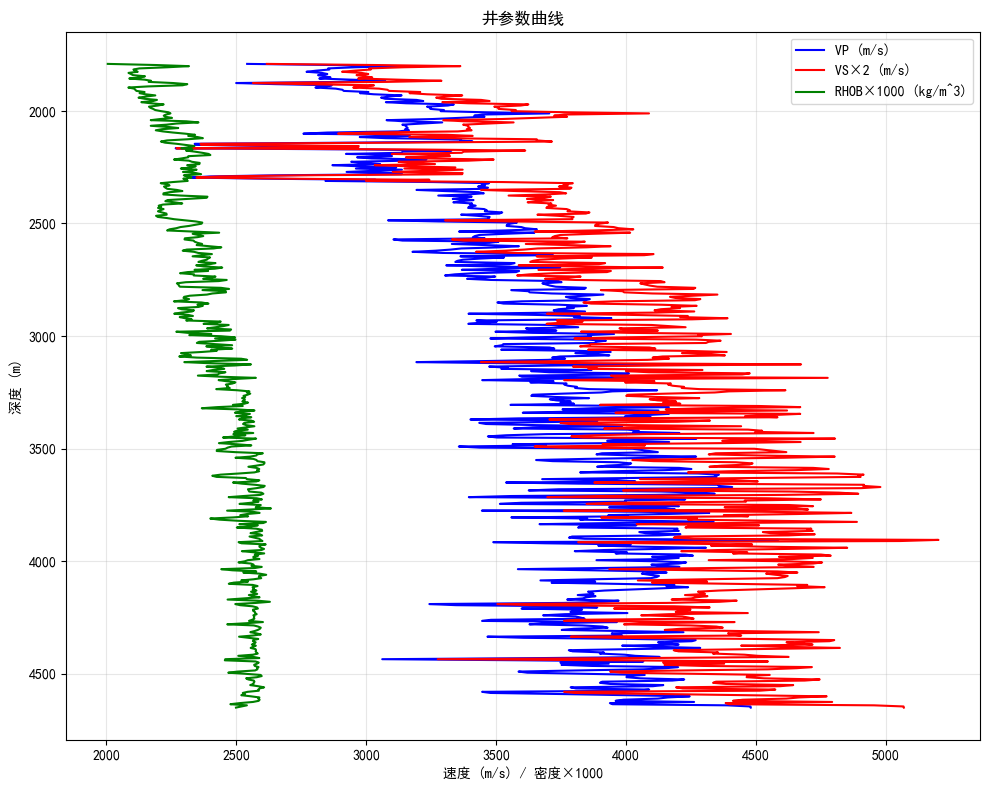

绘制图2: 反射系数对比 (0°)


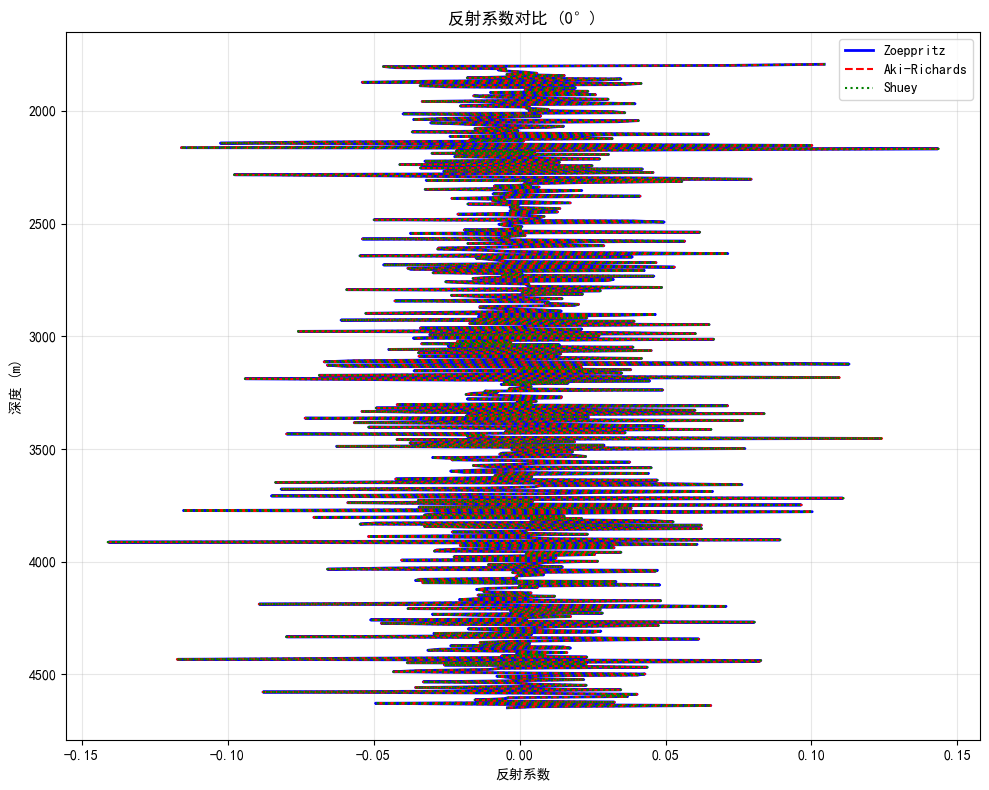

绘制图3: AVO曲线


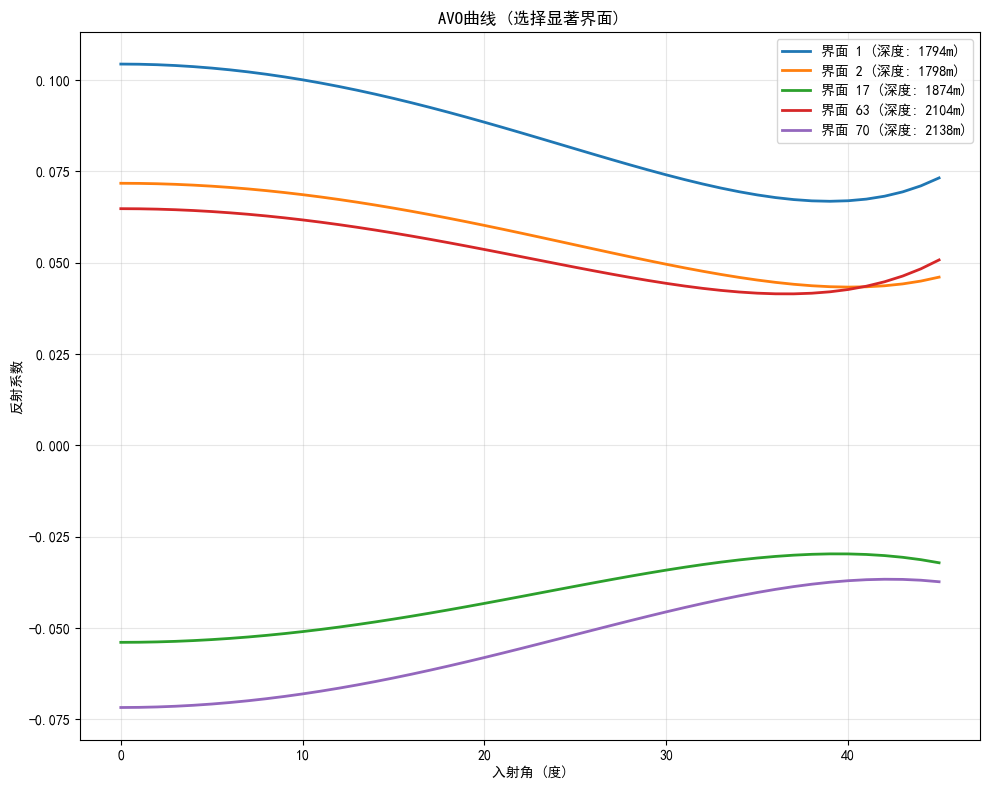

绘制图4: 合成地震道（选择角度）


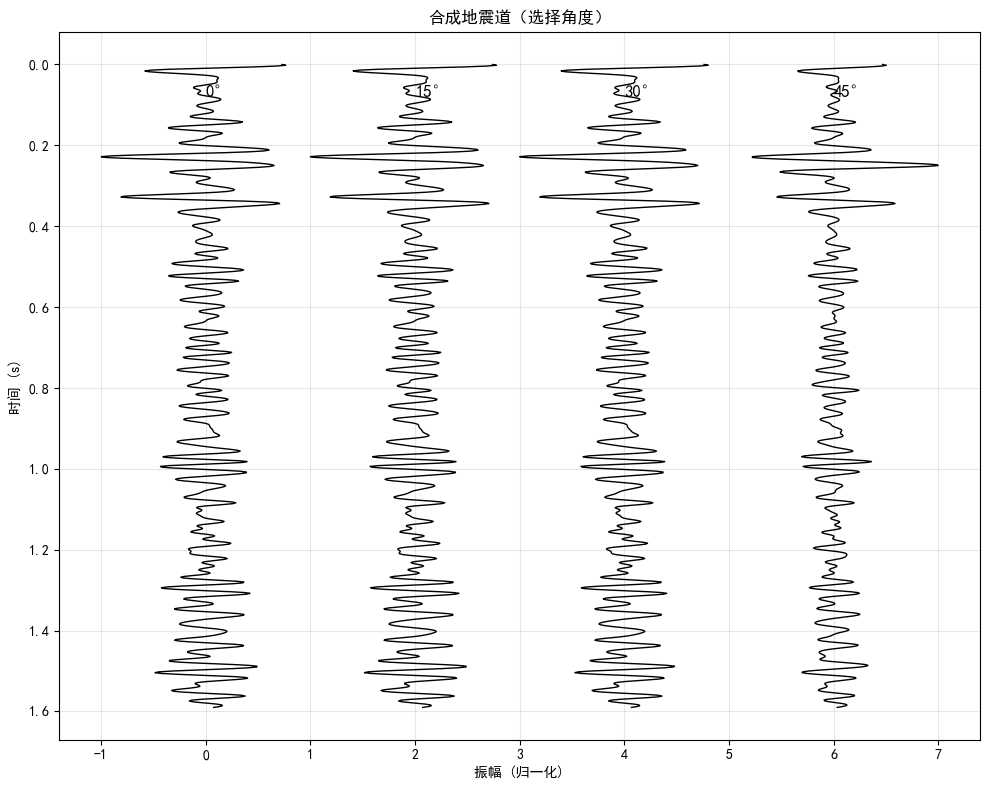

绘制图5: 全角度道集


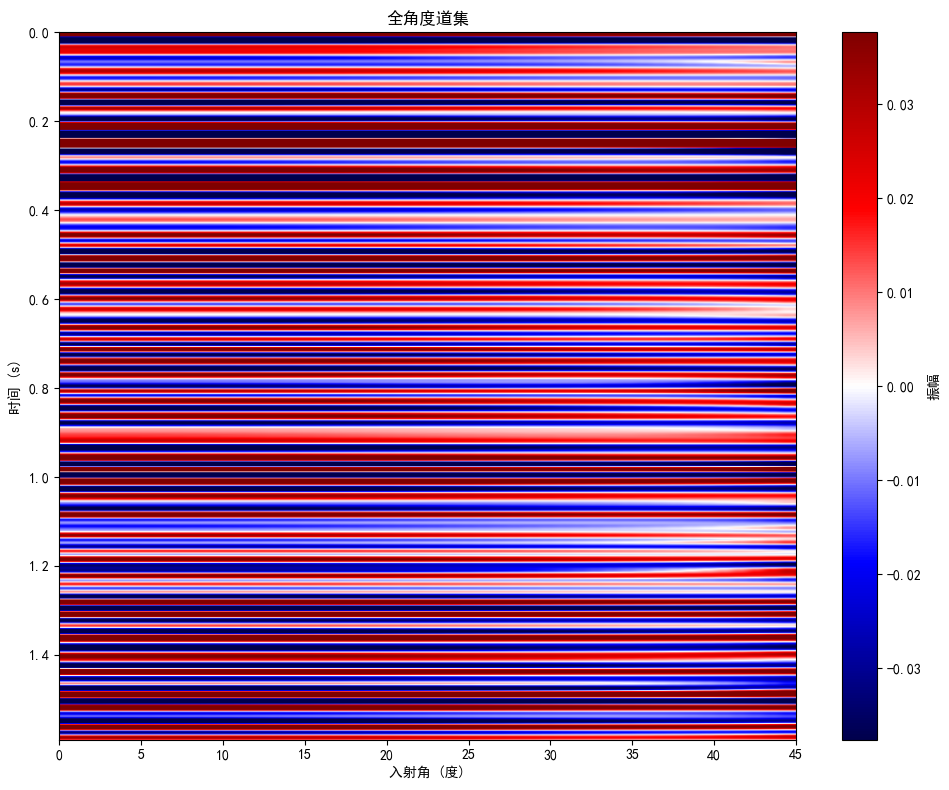

绘制图6: Ricker子波


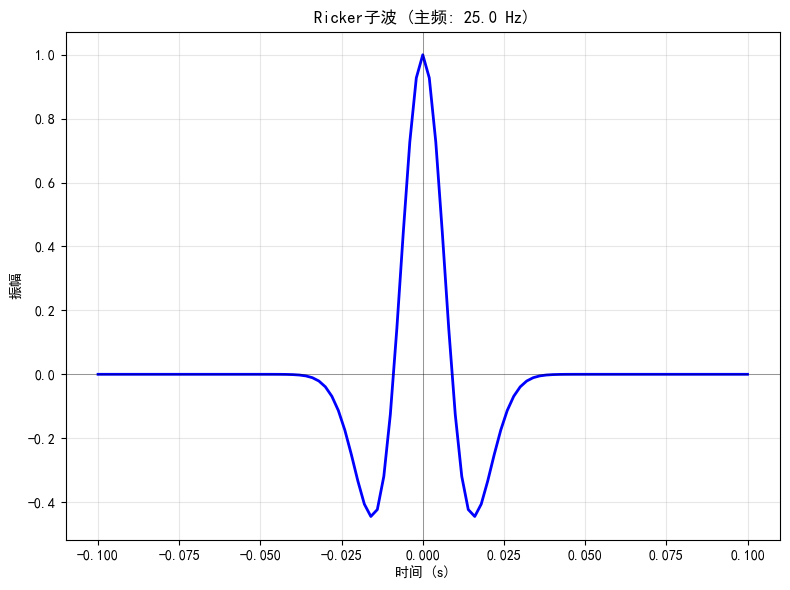

所有图片绘制完成！

AVO正演模拟结果统计摘要
1. 数据规模:
   - 原始井数据: 28591 行
   - 重采样数据: 573 行
   - 识别界面: 572 个
   - 时间样点: 796 个
   - 角度数量: 46 个

2. 物性参数范围:
   - VP: 2267 - 4585 m/s
   - VS: 1135 - 2601 m/s
   - RHOB: 2.01 - 2.63 g/cm³

3. 反射系数统计:
   - Zoeppritz: -0.1407 ~ 0.2157
   - Aki-Richards: -0.1410 ~ 0.2068
   - Shuey: -0.1410 ~ 0.1435

4. 合成地震道统计:
   - 振幅范围: -0.2105 ~ 0.2159
   - 振幅标准差: 0.0376
   - 时间范围: 0.000 - 1.590 s
   - 角度范围: 0° - 45°
开始保存结果到: avo_results
✓ 保存重采样井数据
✓ 保存界面参数
✓ 保存反射系数数据
✓ 保存时间网格
✓ 保存角度信息
✓ 保存合成地震道
生成Ricker子波: 长度=101, 主频=25.0Hz
✓ 保存子波数据
✓ 保存配置参数
✓ 保存数据说明文件

所有结果已保存到: avo_results
保存的文件:
  00_config_parameters.csv            (0.3 KB)
  01_resampled_well_data.csv          (35.6 KB)
  02_interfaces.csv                   (66.5 KB)
  03_reflectivity_zoeppritz.csv       (555.4 KB)
  04_reflectivity_aki_richards.csv    (555.4 KB)
  05_reflectivity_shuey.csv           (555.5 KB)
  06_time_grid.csv                    (9.6 KB)
  07_angles.csv                       (0.3 KB)
  08_synthetic_tr

In [36]:
# =============================================================================
# 8. 运行示例
# =============================================================================

# 创建配置
config = AVOConfig()
config.f_dom = 25.0  # 主频 25 Hz
config.angle_max = 45  # 最大角度45度（可调整）
config.dt = 0.002  # 2ms采样

# 创建AVO正演对象
avo_model = AVOForwardModeling(config)

print("尝试加载PH1.xlsx文件...")
excel_path = "PH1.xlsx"
avo_model.run_full_workflow(excel_path)

# 绘制结果
avo_model.plot_results()

# 获取统计摘要
avo_model.get_summary_stats()

# 保存结果
avo_model.save_results("avo_results")

print("\n✓ AVO正演模拟完成！")
print("\n" + "=" * 60)
print("使用说明:")
print("1. 确保您的Excel文件包含以下列：")
print("   - DEPTH: 深度 (m)")
print("   - VP: P波速度 (m/s)")
print("   - VS: S波速度 (m/s)")
print("   - RHOB: 密度 (g/cm³)")
print("2. 根据需要调整 AVOConfig 中的参数")
print("3. 运行代码即可完成AVO正演模拟")
print("=" * 60)